#### Cloning the Github repo 

In [6]:
!git clone https://github.com/rezazad68/FRCU-Net.git

Cloning into 'FRCU-Net'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 67 (delta 16), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (67/67), 1.78 MiB | 6.40 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [45]:
!cp -r /kaggle/working/FRCU-Net/data17 /kaggle/working/data17


In [5]:
!mv /kaggle/working/FRCU-Net/dataset_isic18 /kaggle/working/FRCU-Net/ISIC2018


#### Dividing the Dataset into training, validation and testing sets

In [12]:
import glob
import numpy as np
import sc

ModuleNotFoundError: No module named 'sc'

In [14]:
import numpy as np
import glob
import imageio
from skimage.transform import resize

# Parameters
height = 256
width  = 256
channels = 3

Dataset_add = '/kaggle/working/FRCU-Net/ISIC2018/'
Tr_add = 'ISIC2018_Task1-2_Training_Input'

Tr_list = glob.glob(Dataset_add + Tr_add + '/*.jpg')
# It contains 1000 training samples
Data_train_2018    = np.zeros([1000, height, width, channels])
Label_train_2018   = np.zeros([1000, height, width])

print('Reading ISIC 2018')
for idx in range(len(Tr_list)):
    print(idx+1)
    img = imageio.imread(Tr_list[idx])
    img = resize(img, (height, width, channels), order=1, mode='reflect', anti_aliasing=True)
    Data_train_2018[idx, :,:,:] = img

    b = Tr_list[idx]    
    a = b[0:len(Dataset_add)]
    b = b[len(b)-16: len(b)-4] 
    add = (a + 'ISIC2018_Task1_Training_GroundTruth/' + b + '_segmentation.png')    
    img2 = imageio.imread(add)
    img2 = resize(img2, (height, width), order=1, mode='reflect', anti_aliasing=True)
    Label_train_2018[idx, :,:] = img2    
         
print('Reading ISIC 2018 finished')

# Make the train, validation, and test sets
Train_img      = Data_train_2018[0:700,:,:,:]
Validation_img = Data_train_2018[700:900,:,:,:]
Test_img       = Data_train_2018[900:1000,:,:,:]

Train_mask      = Label_train_2018[0:700,:,:]
Validation_mask = Label_train_2018[700:900,:,:]
Test_mask       = Label_train_2018[900:1000,:,:]

np.save('data17/data_train', Train_img)
np.save('data17/data_val', Validation_img)
np.save('data17/data_test', Test_img)
np.save('data17/mask_train', Train_mask)
np.save('data17/mask_val', Validation_mask)
np.save('data17/mask_test', Test_mask)


Reading ISIC 2018
1
2


<ipython-input-14-0f5e7731b006>:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(Tr_list[idx])
<ipython-input-14-0f5e7731b006>:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(add)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452


FileNotFoundError: [Errno 2] No such file or directory: 'data17/data_train.npy'

#### Model Training

In [19]:
%cd /kaggle/working/FRCU-Net


/kaggle/working/FRCU-Net


In [51]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun  8 18:15:43 2019
@author: Reza Azad
"""
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import new_model as M
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import callbacks
import pickle

# ===== normalize over the dataset 
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized
       
    
####################################  Load Data #####################################
base_add = '/kaggle/working/data17/'
tr_data    = np.load(base_add+'data_train.npy')
val_data   = np.load(base_add+'data_val.npy')

tr_mask    = np.load(base_add+'mask_train.npy')
val_mask   = np.load(base_add+'mask_val.npy')

tr_mask    = np.expand_dims(tr_mask, axis=3)
val_mask   = np.expand_dims(val_mask, axis=3)

print('ISIC18 Dataset loaded')

tr_data   = dataset_normalized(tr_data)
val_data  = dataset_normalized(val_data)

tr_mask   = tr_mask /255.
val_mask  = val_mask /255.

print('dataset Normalized')

# Build model
model = M.mymodel(input_shape = (256, 256, 3))
model.summary()

print('Training')
batch_size = 12
nb_epoch   = 100


mcp_save = ModelCheckpoint('weight_model17.keras', save_best_only=True, monitor='val_acc', mode='max')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model.fit(tr_data, tr_mask,
              batch_size=batch_size,
              epochs=nb_epoch,
              shuffle=True,
              verbose=1,
              validation_data=(val_data, val_mask), callbacks=[mcp_save, reduce_lr_loss] )

ISIC18 Dataset loaded
dataset Normalized


Model: "new"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_1        │ (None, 128, 128, 32)   │            864 │ input_layer_5[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_1_BN     │ (None, 128, 128, 32)   │            128 │ entry_flow_conv1_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_345            │ (None, 128, 128, 32)   │              0 │ entry_flow_conv1_1_BN… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_2        │ (None, 128, 128, 64)   │         18,432 │ activation_345[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_2_BN     │ (None, 128, 128, 64)   │            256 │ entry_flow_conv1_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_346            │ (None, 128, 128, 64)   │              0 │ entry_flow_conv1_2_BN… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_347            │ (None, 128, 128, 64)   │              0 │ activation_346[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 64)   │            576 │ activation_347[0][0]   │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 64)   │            256 │ entry_flow_block1_sep… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 128)  │          8,192 │ entry_flow_block1_sep… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 128)  │            512 │ entry_flow_block1_sep… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_348            │ (None, 128, 128, 128)  │              0 │ entry_flow_block1_sep… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 68,840,741 (262.61 MB)

 Trainable params: 68,612,533 (261.74 MB)

 Non-trainable params: 228,208 (891.44 KB)

Training
Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 389s 3s/step - accuracy: 0.7152 - loss: 0.0112 - val_accuracy: 0.7142 - val_loss: 0.0093 - learning_rate: 1.0000e-04
Epoch 2/100


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7170 - loss: 0.0072 - val_accuracy: 0.7142 - val_loss: 0.0074 - learning_rate: 1.0000e-04
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7179 - loss: 0.0071 - val_accuracy: 0.7142 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7201 - loss: 0.0070 - val_accuracy: 0.7142 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7148 - loss: 0.0071 - val_accuracy: 0.7142 - val_loss: 0.0072 - learning_rate: 1.0000e-04
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7220 - loss: 0.0069 - val_accuracy: 0.7142 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.7231 - loss: 0.0069 - val_accuracy: 0.7142 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.7152 - loss: 0.00

In [52]:
# Save the final model
model.save('final_model.keras')


ValueError: The filename must end in `.weights.h5`. Received: filepath=final_model_weights.h5

#### Model Performance Evaluation

In [1]:
%cd /kaggle/working/FRCU-Net

/kaggle/working/FRCU-Net


ISIC18 Dataset loaded


Model: "new"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_1        │ (None, 128, 128, 32)   │            864 │ input_layer_5[0][0]    │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_1_BN     │ (None, 128, 128, 32)   │            128 │ entry_flow_conv1_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_345            │ (None, 128, 128, 32)   │              0 │ entry_flow_conv1_1_BN… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_2        │ (None, 128, 128, 64)   │         18,432 │ activation_345[0][0]   │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_conv1_2_BN     │ (None, 128, 128, 64)   │            256 │ entry_flow_conv1_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_346            │ (None, 128, 128, 64)   │              0 │ entry_flow_conv1_2_BN… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_347            │ (None, 128, 128, 64)   │              0 │ activation_346[0][0]   │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 64)   │            576 │ activation_347[0][0]   │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 64)   │            256 │ entry_flow_block1_sep… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 128)  │          8,192 │ entry_flow_block1_sep… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ entry_flow_block1_separa… │ (None, 128, 128, 128)  │            512 │ entry_flow_block1_sep… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_348            │ (None, 128, 128, 128)  │              0 │ entry_flow_block1_sep… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 206,065,809 (786.08 MB)

 Trainable params: 68,612,533 (261.74 MB)

 Non-trainable params: 228,208 (891.44 KB)

 Optimizer params: 137,225,068 (523.47 MB)

13/13 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step 
(6553600, 1)

Area under the ROC curve: 0.5

Area under Precision-Recall curve: 0.6379410552978515

Confusion matrix: Custom threshold (for positive) of 0.5
[[4745579       0]
 [1808021       0]]
Global Accuracy: 0.7241178894042969
Specificity: 1.0
Sensitivity: 0.0
Precision: 0

Jaccard similarity score: 0.0

F1 score (F-measure): 0.0


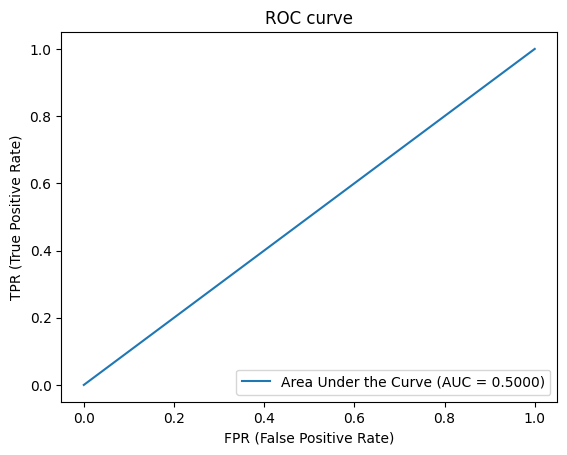

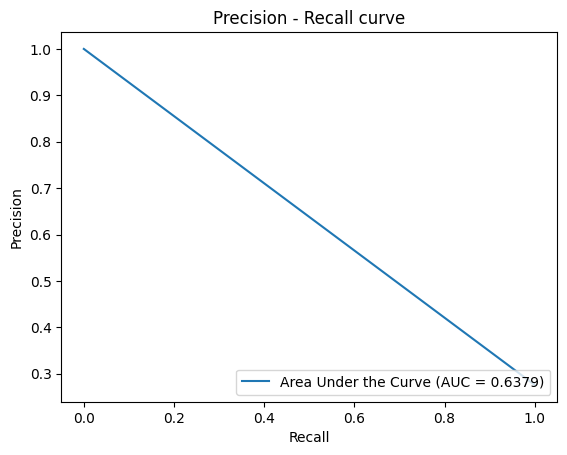

In [6]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun  8 18:15:43 2019
@author: Reza Azad
"""
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, jaccard_score, f1_score
from tensorflow.keras.models import load_model

# ===== normalize over the dataset
def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs-imgs_mean)/imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i])-np.min(imgs_normalized[i])))*255
    return imgs_normalized
    
####################################  Load Data #####################################
base_add = './data17/'
te_data    = np.load(base_add+'data_test.npy')
te_mask    = np.load(base_add+'mask_test.npy')
te_mask    = np.expand_dims(te_mask, axis=3)

print('ISIC18 Dataset loaded')

te_data  = dataset_normalized(te_data)

# Load the final saved model
model_path = 'final_model.keras'
model = load_model(model_path)
model.summary()

# Predict on test data
predictions = model.predict(te_data, batch_size=8, verbose=1)

y_scores = predictions.reshape(predictions.shape[0]*predictions.shape[1]*predictions.shape[2]*predictions.shape[3], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2]*te_mask.shape[3], 1)

y_scores = np.where(y_scores > 0.5, 1, 0)
y_true   = np.where(y_true > 0.5, 1, 0)

output_folder = 'output/'
os.makedirs(output_folder, exist_ok=True)

# Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print("\nArea under the ROC curve: " + str(AUC_ROC))
roc_curve_plot = plt.figure()
plt.plot(fpr, tpr, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder + "ROC.png")

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0] 
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision, recall)
print("\nArea under Precision-Recall curve: " + str(AUC_prec_rec))
prec_rec_curve_plot = plt.figure()
plt.plot(recall, precision, '-', label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder + "Precision_recall.png")

# Confusion matrix
threshold_confusion = 0.5
print("\nConfusion matrix: Custom threshold (for positive) of " + str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i] >= threshold_confusion:
        y_pred[i] = 1
    else:
        y_pred[i] = 0
confusion = confusion_matrix(y_true, y_pred)
print(confusion)
accuracy = float(confusion[0, 0] + confusion[1, 1]) / float(np.sum(confusion)) if float(np.sum(confusion)) != 0 else 0
print("Global Accuracy: " + str(accuracy))
specificity = float(confusion[0, 0]) / float(confusion[0, 0] + confusion[0, 1]) if float(confusion[0, 0] + confusion[0, 1]) != 0 else 0
print("Specificity: " + str(specificity))
sensitivity = float(confusion[1, 1]) / float(confusion[1, 1] + confusion[1, 0]) if float(confusion[1, 1] + confusion[1, 0]) != 0 else 0
print("Sensitivity: " + str(sensitivity))
precision_value = float(confusion[1, 1]) / float(confusion[1, 1] + confusion[0, 1]) if float(confusion[1, 1] + confusion[0, 1]) != 0 else 0
print("Precision: " + str(precision_value))

# Jaccard similarity index
jaccard_index = jaccard_score(y_true, y_pred)
print("\nJaccard similarity score: " + str(jaccard_index))

# F1 score
F1_score = f1_score(y_true, y_pred)
print("\nF1 score (F-measure): " + str(F1_score))


#### Testing

In [7]:
from tensorflow.keras.models import load_model

# Load the final model
model = load_model('/kaggle/working/FRCU-Net/final_model.keras')

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 719ms/step


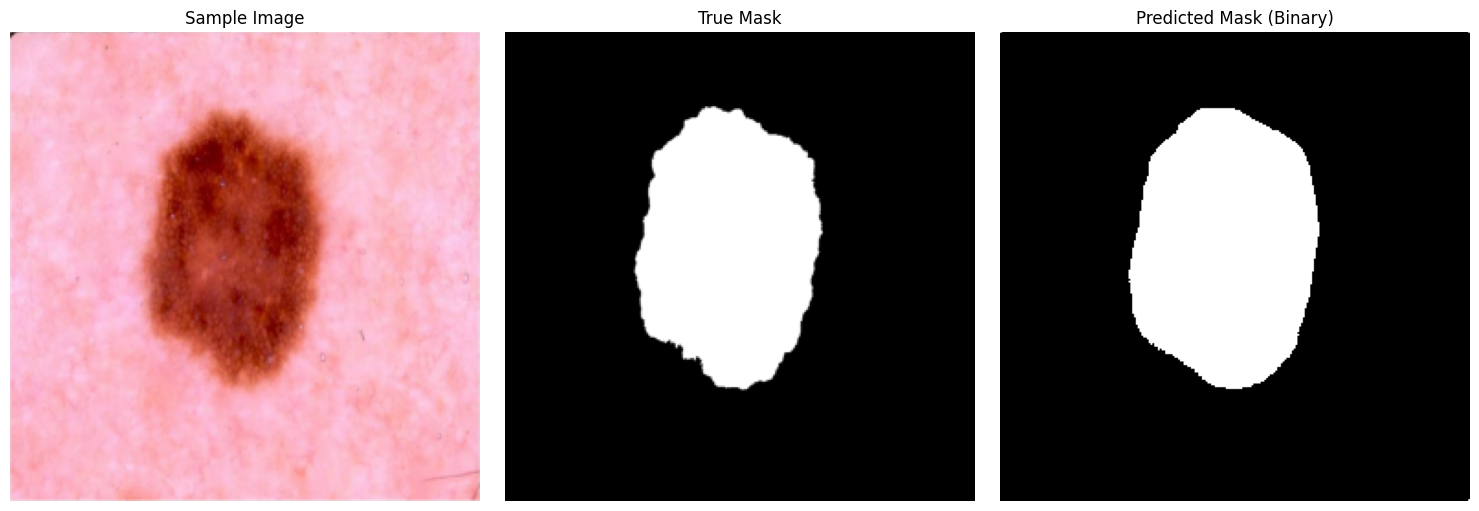

Test data shape: (100, 256, 256, 3)
Test mask shape: (100, 256, 256)
Predictions shape: (100, 256, 256, 1)


In [13]:
import numpy as np
import matplotlib.pyplot as plt


# Load and normalize the test dataset
base_add = './data17/'
te_data = np.load(base_add + 'data_test.npy')
te_mask = np.load(base_add + 'mask_test.npy')

def dataset_normalized(imgs):
    imgs_normalized = np.empty(imgs.shape)
    imgs_std = np.std(imgs)
    imgs_mean = np.mean(imgs)
    imgs_normalized = (imgs - imgs_mean) / imgs_std
    for i in range(imgs.shape[0]):
        imgs_normalized[i] = ((imgs_normalized[i] - np.min(imgs_normalized[i])) / (np.max(imgs_normalized[i]) - np.min(imgs_normalized[i]))) * 255
    return imgs_normalized

te_data = dataset_normalized(te_data)
te_mask = te_mask / 255.0  # Normalize masks to [0, 1]

# Make predictions
predictions = model.predict(te_data)

# Apply a threshold to make predictions binary
binary_predictions = (predictions > 1e-3).astype(np.uint8)

# Display a sample image, its true mask, and predicted mask
sample_idx = np.random.randint(0, te_data.shape[0])
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(te_data[sample_idx].astype(np.uint8))
ax1.set_title('Sample Image')
ax1.axis('off')

ax2.imshow(te_mask[sample_idx].squeeze(), cmap='gray')
ax2.set_title('True Mask')
ax2.axis('off')

ax3.imshow(binary_predictions[sample_idx].squeeze(), cmap='gray')
ax3.set_title('Predicted Mask (Binary)')
ax3.axis('off')

plt.tight_layout()
plt.show()

# Print shapes and verify binary values
print(f"Test data shape: {te_data.shape}")
print(f"Test mask shape: {te_mask.shape}")
print(f"Predictions shape: {binary_predictions.shape}")


#### File relocation and Handling

In [22]:
with open('/kaggle/working/FRCU-Net/new_model.py', 'r') as file:
    content = file.read()


In [24]:
content = content.replace('from keras', 'from tensorflow.keras')
content = content.replace('from keras.engine', 'from tensorflow.keras.layers')


In [25]:
with open('new_model.py', 'w') as file:
    file.write(content)


In [27]:
import os

file_to_delete = '/kaggle/working/FRCU-Net/new_model.py'
if os.path.isfile(file_to_delete):
    os.remove(file_to_delete)
    print(f"File {file_to_delete} has been deleted.")
else:
    print(f"File {file_to_delete} does not exist.")


File /kaggle/working/FRCU-Net/new_model.py has been deleted.


In [28]:
import shutil
import os

# Define the source and destination paths
source_path = '/kaggle/input/modelpy/new_model.py'
destination_path = '/kaggle/working/FRCU-Net/new_model.py'

# Copy the file
shutil.copy2(source_path, destination_path)

# Verify that the file was copied
if os.path.isfile(destination_path):
    print(f"File successfully copied to {destination_path}")
else:
    print("File copy failed")


File successfully copied to /kaggle/working/FRCU-Net/new_model.py


In [47]:
# Read the content of the file
with open('/kaggle/working/FRCU-Net/new_model.py', 'r') as file:
    content = file.read()

# Define the replacements
replacements = [
    ('from keras', 'from tensorflow.keras'),
    ('from keras.engine import Layer', 'from tensorflow.keras.layers import Layer'),
    ('from keras.engine import InputSpec', 'from tensorflow.keras.layers import InputSpec'),
    ('from keras.engine.topology import get_source_inputs', 'from tensorflow.keras.utils import get_source_inputs'),
    ('from keras.optimizers import Adam', 'from tensorflow.keras.optimizers import Adam'),
    ('from keras.applications import imagenet_utils', 'from tensorflow.keras.applications import imagenet_utils'),
    ('from keras.utils import conv_utils', 'from tensorflow.keras.utils import conv_utils'),
    ('from keras.layers.core import Lambda', 'from tensorflow.keras.layers import Lambda'),
    ('from keras.utils.data_utils import get_file', 'from tensorflow.keras.utils import get_file'),
    ('from keras.layers import Add', 'from tensorflow.keras.layers import Add'),
    ('import keras.backend as K', 'import tensorflow.keras.backend as K'),
    ('from keras import backend as K', 'from tensorflow.keras import backend as K'),
    ('from tensorflow.keras.engine import Layer','from tensorflow.keras.layers import Layer'),
    ('from tensorflow.keras.engine import InputSpec','from tensorflow.keras.layers import InputSpec'),
    ('from tensorflow.keras.engine.topology import get_source_inputs','from tensorflow.keras.utils import get_source_inputs'),
    ('from tensorflow.keras.utils import conv_utils','from tensorflow.python.keras.utils import conv_utils'),
    ('from tensorflow.keras.layers.core import Lambda','from tensorflow.keras.layers import Lambda'),
    ('from tensorflow.keras.utils.data_utils import get_file','from tensorflow.keras.utils import get_file')

]

# Apply the replacements
for old, new in replacements:
    content = content.replace(old, new)

# Write the modified content back to the file
with open('new_model.py', 'w') as file:
    file.write(content)

print("new_model.py has been updated with the necessary changes.")


new_model.py has been updated with the necessary changes.


In [49]:
# Read the content of the file
with open('Train_Skin_Lesion_Segmentation.py', 'r') as file:
    content = file.read()

# Define the replacements
replacements = [
    ("mcp_save = ModelCheckpoint('weight_model17', save_best_only=True, monitor='val_acc', mode='max')",
     "mcp_save = ModelCheckpoint('weight_model17.keras', save_best_only=True, monitor='val_accuracy', mode='max')"),
    
    ("reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')",
     "reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')"),
    
    ("history = model.fit(tr_data, tr_mask,",
     "history = model.fit(tr_data, tr_mask,")
]

# Apply the replacements
for old, new in replacements:
    content = content.replace(old, new)

# Write the modified content back to the file
with open('Train_Skin_Lesion_Segmentation.py', 'w') as file:
    file.write(content)

print("Train_Skin_Lesion_Segmentation.py has been updated with the necessary changes.")


Train_Skin_Lesion_Segmentation.py has been updated with the necessary changes.


In [30]:
import shutil
import os

# Define the source and destination paths
source_path = '/kaggle/working/data17'
destination_path = '/kaggle/working/FRCU-Net'

# Move the folder
shutil.move(source_path, destination_path)

# Verify that the folder was moved
if os.path.exists(destination_path):
    print(f"Folder successfully moved to {destination_path}")
else:
    print("Folder move failed")


Folder successfully moved to /kaggle/working/FRCU-Net
